## **Benchmark problem**: Consolidation of a finite aquifer layer (Terzaghi's Problem)

We benchmark our 2D poroelastic finite-difference code (see Description-of-aquifer-model.md) by comparing it to the analytical solutions of Terzaghi's 1D consolidation problem (Wang, 2000). In this problem, a compressive stress $-\sigma_o$ is suddenly applied at $t = 0^+$ at the top of an H x L finite unconfined aquifer with rigid, impermeable sides and basement such that the following boundary conditions arise: 

Top boundary:
$$\sigma_{yy}(x,y=H,t) = -\sigma_o$$
$$\sigma_{xy}(x,y=H,t) = 0$$
$$p(x,y=H,t) = 0$$

Bottom boundary: 
$$u(x,y=0,t) = 0$$
$$v(x,y=0,t) = 0$$
$$\frac{\partial p}{\partial y}(x,y=0,t) = 0$$

Left boundary: 
$$u(x=0,y,t) = 0$$
$$\frac{\partial v}{\partial x}(x=0,y,t) = 0$$
$$\frac{\partial p}{\partial x}(x=0,y,t) = 0$$

Right boundary: 
$$u(x=L,y,t) = 0$$
$$\frac{\partial v}{\partial x}(x=L,y,t) = 0$$
$$\frac{\partial p}{\partial x}(x=L,y,t) = 0$$

which entail that:

1) Vertical normal stress $\sigma_{yy}$ is constant through time and space and is equal to $-\sigma_o$
2) Horizontal displacement $u$ is zero everywhere, i.e., the aquifer is in a state of uniaxial strain.
3) Vertical displacment $v$ is independent of $x$.

To obtain accurate solutions at early time steps, we must initialize the problem with the correct initial conditions at $t = 0^+$, namely: 
$$u(x,y,t=0^+) = 0$$
$$v(x,y,t=0^+) = -\frac{1-2\nu_u}{2G(1-\nu_u)}\sigma_o(y+H)$$
$$p(x,y,t=0^+) = \frac{\nu_u-\nu}{\alpha(1-2\nu)(1-\nu_u)}\sigma_o$$

The analytical solutions are as follows: 
$$u(x,y,t) = 0$$
$$p(x,y,t) = -\frac{4\gamma\sigma_o}{\pi}\sum_{m=0}^{\infty}\frac{1}{2m+1}\exp\left[\frac{-(2m+1)^2\pi^2ct}{4H^2}\right]\sin\left[\frac{(2m+1)\pi y}{2H}\right] $$
$$v(x,y,t) = -\frac{1-2\nu_u}{2G(1-\nu_u)}\sigma_o(y+H)-c_m\gamma\sigma_o\left((y+H)-\frac{8H}{\pi^2}\sum_{m=0}^\infty\frac{1}{(2m+1)^2}\exp\left[\frac{-(2m+1)^2\pi^2 ct}{4H^2}\right]\cos\left[\frac{(2m+1)\pi y}{2H}\right]\right)$$

Reference:
H. F. Wang (2000), *Theory of Linear Poroelasticity with Applications to Geomechanics and Hydrogeology*, Princeton University Press.



In [1]:
from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'
rcParams['font.size'] = 12
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors

import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import inv
from scipy import special as sp
import time

np.set_printoptions(threshold=np.inf)
%matplotlib widget

In [2]:
## Poroelastic properties:
G = 10e9 # Shear modulus [GPa]
nu = 0.25 # Drained Poisson's ratio
nu_u = 0.35 # Undrained Poisson's ratio
alpha = 0.9 # Biot coefficient
rho_o = 1000 # Reference water density [kg/m^3]
g = 10 # gravitational acceleration
k = 1e-13 # Aquifer permeability [m^2]
mu = 1e-3 # Dynamic viscosity of water [kg/(m·s)] 
c_m = alpha*(1-2*nu)/(2*(1-nu)*G) # Uniaxial poroelastic expansion coefficient
gamma = 1/alpha*(nu_u-nu)/((1-2*nu)*(1-nu_u)) #Loading efficiency
c = k*gamma/(mu*c_m) #hydraulic diffusivity [m^2/s]
B = 3*(nu_u-nu)/(alpha*(1-2*nu)*(1+nu_u)) # Skempton's coefficient
S = k/(mu*c) # Uniaxial specific storage
S_eps = (1-nu)*(1-2*nu_u)/((1-nu_u)*(1-2*nu))*S #Specific storage at constant strain

## Model domain
L = 100 # Width of domain [m]
H = 1000 # Height of domain [m]

## Numerical parameters:
dt = 1000 # timestep [s]
nt = 100 # Number of timesteps to compute
times = np.arange(dt,(nt+1)*dt,dt) # Time array
n_plot = 10 #Plot every n_plot time step
dx = 10 # Discretization in x-direction
dy = 10 # Discretization in y-direction
x = np.arange(-L/2,L/2+dx,dx) # x gridpoints
y = np.arange(-H,dy,dy) # y gridpoints
[x2d,y2d] = np.meshgrid(x,y) # x and y mesh
nx = len(x) # Number of gridpoints in x direction
ny = len(y) # Number of gridpoints in y direction

## Surface loading:
sigma_o = 1e6 # Amplitude of applied stress [Pa]
sigma_surf = -sigma_o #Stress at the surface (negative = compressive loading)

## Setup arrays for variables to be solved for:
p = gamma*sigma_o*np.ones([nx*ny,1]) # Initial pore pressure [Pa]
u = np.zeros([nx*ny,1]) # Initial horizontal displacements [m]
v = -(1-2*nu_u)/(2*G*(1-nu_u))*sigma_o*(y2d.T+H) # Initial vertical displacements [m]
v = v.flatten()

## Setup array to verify vertical stress:
sigma_yy = np.zeros((ny-2,1))

## Array of indices:
Number = np.arange(0,nx*ny) 
Number = Number.reshape((nx,ny))

In [3]:
# Construct A matrix to be inverted:

A1_p = np.zeros((nx*ny,nx*ny)) #Pressure portion of fluid equation
A1_u = np.zeros((nx*ny,nx*ny)) #x-displacement portion of fluid equation
A1_v = np.zeros((nx*ny,nx*ny)) #y-displacement portion of fluid equation

A2_p = np.zeros((nx*ny,nx*ny)) #Pressure portion of first mechanical equation
A2_u = np.zeros((nx*ny,nx*ny)) #x-displacement portion of first mechanical equation
A2_v = np.zeros((nx*ny,nx*ny)) #y-displacement portion of first mechanical equation

A3_p = np.zeros((nx*ny,nx*ny)) #Pressure portion of second mechanical equation
A3_u = np.zeros((nx*ny,nx*ny)) #x-displacement portion of second mechanical equation
A3_v = np.zeros((nx*ny,nx*ny)) #y-displacement portion of second mechanical equation


for i in np.arange(0,nx):
    for j in np.arange(0,ny):   

        # Top boundary:
        if j == ny-1: 
            A1_p[Number[i,j],Number[i,j]] = 1 # p = 0 everywhere at top boundary

            # Upper left corner:
            if i == 0:
                #A2_p[Number[i,j],Number[i+1,j]] = -alpha/(2*dx*G)
                #A2_p[Number[i,j],Number[i-1,j]] = alpha/(2*dx*G)   
                A2_u[Number[i,j],Number[i,j]] = -2*((2-2*nu)/(1-2*nu)*(1/dx**2)+1/dy**2-nu/((1-2*nu)*(1-nu))*(1/(4*dx**2)))
                A2_u[Number[i,j],Number[i+1,j]] = (2-2*nu)/(1-2*nu)*(1/dx**2)
                #A2_u[Number[i,j],Number[i-1,j]] = (2-2*nu)/(1-2*nu)*(1/dx**2)
                #A2_u[Number[i,j],Number[i,j+1]] = 1/dy**2
                A2_u[Number[i,j],Number[i,j-1]] = 2/dy**2
                A2_u[Number[i,j],Number[i+2,j]] = -nu/((1-2*nu)*(1-nu))*(1/(4*dx**2))
                #A2_u[Number[i,j],Number[i-2,j]] = -nu/((1-2*nu)*(1-nu))*(1/(4*dx**2))
                #A2_v[Number[i,j],Number[i+1,j]] = -1/(dx*dy)
                #A2_v[Number[i,j],Number[i-1,j]] = 1/(dx*dy)
                
               #A3_p[Number[i,j],Number[i,j+1]] = -alpha/(2*dy*G) 
                A3_p[Number[i,j],Number[i,j-1]] = 2*alpha/(2*dy*G)
                A3_u[Number[i,j],Number[i+1,j]] = -2*nu/((1-2*nu)*dx*dy)
                #A3_u[Number[i,j],Number[i-1,j]] = 2*nu/((1-2*nu)*dx*dy)
                A3_v[Number[i,j],Number[i,j-1]] = 2*(2-2*nu)/((1-2*nu)*dy**2)
                A3_v[Number[i,j],Number[i+1,j]] = 2/(dx**2)
                #A3_v[Number[i,j],Number[i-1,j]] = 1/(dx**2)
                A3_v[Number[i,j],Number[i+2,j]] = -1/((1-2*nu)*4*dx**2)
                #A3_v[Number[i,j],Number[i-2,j]] = -1/((1-2*nu)*4*dx**2)
                A3_v[Number[i,j],Number[i,j]] = -2*(2-2*nu)/((1-2*nu)*dy**2)-2/(dx**2)+1/(2*(1-2*nu)*dx**2)-1/((1-2*nu)*4*dx**2)   
            
            # Gridpoint to the right of upper left corner (necessary because of the i-2 term):
            elif i == 1:
                A2_p[Number[i,j],Number[i+1,j]] = -alpha/(2*dx*G)
                A2_p[Number[i,j],Number[i-1,j]] = alpha/(2*dx*G)
                A2_u[Number[i,j],Number[i,j]] = -2*((2-2*nu)/(1-2*nu)*(1/dx**2)+1/dy**2-nu/((1-2*nu)*(1-nu))*(1/(4*dx**2)))
                A2_u[Number[i,j],Number[i+1,j]] = (2-2*nu)/(1-2*nu)*(1/dx**2)
                A2_u[Number[i,j],Number[i-1,j]] = (2-2*nu)/(1-2*nu)*(1/dx**2)
                #A2_u[Number[i,j],Number[i,j+1]] = 1/dy**2
                A2_u[Number[i,j],Number[i,j-1]] = 2/dy**2
                A2_u[Number[i,j],Number[i+2,j]] = -nu/((1-2*nu)*(1-nu))*(1/(4*dx**2))
                #A2_u[Number[i,j],Number[i-2,j]] = -nu/((1-2*nu)*(1-nu))*(1/(4*dx**2))
                # A2_v[Number[i,j],Number[i+1,j]] = -1/(dx*dy)
                # A2_v[Number[i,j],Number[i-1,j]] = 1/(dx*dy)  
                
               #A3_p[Number[i,j],Number[i,j+1]] = -alpha/(2*dy*G) 
                A3_p[Number[i,j],Number[i,j-1]] = 2*alpha/(2*dy*G)
                A3_u[Number[i,j],Number[i+1,j]] = -2*nu/((1-2*nu)*dx*dy)
                A3_u[Number[i,j],Number[i-1,j]] = 2*nu/((1-2*nu)*dx*dy)
                A3_v[Number[i,j],Number[i,j-1]] = 2*(2-2*nu)/((1-2*nu)*dy**2)
                A3_v[Number[i,j],Number[i+1,j]] = 1/(dx**2)
                A3_v[Number[i,j],Number[i-1,j]] = 1/(dx**2)
                A3_v[Number[i,j],Number[i+2,j]] = -1/((1-2*nu)*4*dx**2)
                #A3_v[Number[i,j],Number[i-2,j]] = -1/((1-2*nu)*4*dx**2)
                A3_v[Number[i,j],Number[i,j]] = -2*(2-2*nu)/((1-2*nu)*dy**2)-2/(dx**2)+1/(2*(1-2*nu)*dx**2)-1/((1-2*nu)*4*dx**2)                            
            
            # Gridpoint to the left of upper right corner (necessary because of the i+2 term):
            elif i == nx-2:
                A2_p[Number[i,j],Number[i+1,j]] = -alpha/(2*dx*G)
                A2_p[Number[i,j],Number[i-1,j]] = alpha/(2*dx*G)
                A2_u[Number[i,j],Number[i,j]] = -2*((2-2*nu)/(1-2*nu)*(1/dx**2)+1/dy**2-nu/((1-2*nu)*(1-nu))*(1/(4*dx**2)))
                A2_u[Number[i,j],Number[i+1,j]] = (2-2*nu)/(1-2*nu)*(1/dx**2)
                A2_u[Number[i,j],Number[i-1,j]] = (2-2*nu)/(1-2*nu)*(1/dx**2)
                #A2_u[Number[i,j],Number[i,j+1]] = 1/dy**2
                A2_u[Number[i,j],Number[i,j-1]] = 2/dy**2
                #A2_u[Number[i,j],Number[i+2,j]] = -nu/((1-2*nu)*(1-nu))*(1/(4*dx**2))
                A2_u[Number[i,j],Number[i-2,j]] = -nu/((1-2*nu)*(1-nu))*(1/(4*dx**2))
                # A2_v[Number[i,j],Number[i+1,j]] = -1/(dx*dy)
                # A2_v[Number[i,j],Number[i-1,j]] = 1/(dx*dy)
                
               #A3_p[Number[i,j],Number[i,j+1]] = -alpha/(2*dy*G) 
                A3_p[Number[i,j],Number[i,j-1]] = 2*alpha/(2*dy*G)
                A3_u[Number[i,j],Number[i+1,j]] = -2*nu/((1-2*nu)*dx*dy)
                A3_u[Number[i,j],Number[i-1,j]] = 2*nu/((1-2*nu)*dx*dy)
                A3_v[Number[i,j],Number[i,j-1]] = 2*(2-2*nu)/((1-2*nu)*dy**2)
                A3_v[Number[i,j],Number[i+1,j]] = 1/(dx**2)
                A3_v[Number[i,j],Number[i-1,j]] = 1/(dx**2)
                #A3_v[Number[i,j],Number[i+2,j]] = -1/((1-2*nu)*4*dx**2)
                A3_v[Number[i,j],Number[i-2,j]] = -1/((1-2*nu)*4*dx**2)
                A3_v[Number[i,j],Number[i,j]] = -2*(2-2*nu)/((1-2*nu)*dy**2)-2/(dx**2)+1/(2*(1-2*nu)*dx**2)-1/((1-2*nu)*4*dx**2)
                     
            # Upper right corner:        
            elif i == nx-1:    
                #A2_p[Number[i,j],Number[i+1,j]] = -alpha/(2*dx*G)
                #A2_p[Number[i,j],Number[i-1,j]] = alpha/(2*dx*G)               
                A2_u[Number[i,j],Number[i,j]] = -2*((2-2*nu)/(1-2*nu)*(1/dx**2)+1/dy**2-nu/((1-2*nu)*(1-nu))*(1/(4*dx**2)))
                #A2_u[Number[i,j],Number[i+1,j]] = (2-2*nu)/(1-2*nu)*(1/dx**2)
                A2_u[Number[i,j],Number[i-1,j]] = (2-2*nu)/(1-2*nu)*(1/dx**2)
                #A2_u[Number[i,j],Number[i,j+1]] = 1/dy**2
                A2_u[Number[i,j],Number[i,j-1]] = 2/dy**2
                #A2_u[Number[i,j],Number[i+2,j]] = -nu/((1-2*nu)*(1-nu))*(1/(4*dx**2))
                A2_u[Number[i,j],Number[i-2,j]] = -nu/((1-2*nu)*(1-nu))*(1/(4*dx**2))
                #A2_v[Number[i,j],Number[i+1,j]] = -1/(dx*dy)
                #A2_v[Number[i,j],Number[i-1,j]] = 1/(dx*dy)
                
               #A3_p[Number[i,j],Number[i,j+1]] = -alpha/(2*dy*G) 
                A3_p[Number[i,j],Number[i,j-1]] = 2*alpha/(2*dy*G)
                #A3_u[Number[i,j],Number[i+1,j]] = -2*nu/((1-2*nu)*dx*dy)
                A3_u[Number[i,j],Number[i-1,j]] = 2*nu/((1-2*nu)*dx*dy)
                A3_v[Number[i,j],Number[i,j-1]] = 2*(2-2*nu)/((1-2*nu)*dy**2)
                #A3_v[Number[i,j],Number[i+1,j]] = 1/(dx**2)
                A3_v[Number[i,j],Number[i-1,j]] = 2/(dx**2)
                #A3_v[Number[i,j],Number[i+2,j]] = -1/((1-2*nu)*4*dx**2)
                A3_v[Number[i,j],Number[i-2,j]] = -1/((1-2*nu)*4*dx**2)
                A3_v[Number[i,j],Number[i,j]] = -2*(2-2*nu)/((1-2*nu)*dy**2)-2/(dx**2)+1/(2*(1-2*nu)*dx**2)-1/((1-2*nu)*4*dx**2)
            
            # Rest of top boundary:
            else:
                A2_p[Number[i,j],Number[i+1,j]] = -alpha/(2*dx*G)
                A2_p[Number[i,j],Number[i-1,j]] = alpha/(2*dx*G)
                A2_u[Number[i,j],Number[i,j]] = -2*((2-2*nu)/(1-2*nu)*(1/dx**2)+1/dy**2-nu/((1-2*nu)*(1-nu))*(1/(4*dx**2)))
                A2_u[Number[i,j],Number[i+1,j]] = (2-2*nu)/(1-2*nu)*(1/dx**2)
                A2_u[Number[i,j],Number[i-1,j]] = (2-2*nu)/(1-2*nu)*(1/dx**2)
                #A2_u[Number[i,j],Number[i,j+1]] = 1/dy**2
                A2_u[Number[i,j],Number[i,j-1]] = 2/dy**2
                A2_u[Number[i,j],Number[i+2,j]] = -nu/((1-2*nu)*(1-nu))*(1/(4*dx**2))
                A2_u[Number[i,j],Number[i-2,j]] = -nu/((1-2*nu)*(1-nu))*(1/(4*dx**2))
                A2_v[Number[i,j],Number[i+1,j]] = -1/(dx*dy)
                A2_v[Number[i,j],Number[i-1,j]] = 1/(dx*dy)
                
               #A3_p[Number[i,j],Number[i,j+1]] = -alpha/(2*dy*G) # This is specific to p = 0 B.C.
                A3_p[Number[i,j],Number[i,j-1]] = 2*alpha/(2*dy*G)
                A3_u[Number[i,j],Number[i+1,j]] = -2*nu/((1-2*nu)*dx*dy)
                A3_u[Number[i,j],Number[i-1,j]] = 2*nu/((1-2*nu)*dx*dy)
                A3_v[Number[i,j],Number[i,j-1]] = 2*(2-2*nu)/((1-2*nu)*dy**2)
                A3_v[Number[i,j],Number[i+1,j]] = 1/(dx**2)
                A3_v[Number[i,j],Number[i-1,j]] = 1/(dx**2)
                A3_v[Number[i,j],Number[i+2,j]] = -1/((1-2*nu)*4*dx**2)
                A3_v[Number[i,j],Number[i-2,j]] = -1/((1-2*nu)*4*dx**2)
                A3_v[Number[i,j],Number[i,j]] = -2*(2-2*nu)/((1-2*nu)*dy**2)-2/(dx**2)+1/(2*(1-2*nu)*dx**2)
            
        # Bottom boundary:
        elif j == 0:
            
            A2_u[Number[i,j],Number[i,j]] = 1
            A3_v[Number[i,j],Number[i,j]] = 1
            
            # Bottom left corner: 
            if i == 0:
                A1_p[Number[i,j],Number[i+1,j]] = -2*(k/(alpha*mu))/dx**2
                #A1_p[Number[i,j],Number[i-1,j]] = -(k/(alpha*mu))/dx**2
                A1_p[Number[i,j],Number[i,j+1]] = -2*(k/(alpha*mu))/dy**2
                #A1_p[Number[i,j],Number[i,j-1]] = -(k/(alpha*mu))/dy**2
                A1_p[Number[i,j],Number[i,j]] = (2*k/(alpha*mu))*(1/dx**2+1/dy**2)+S_eps/(alpha*dt)
                A1_u[Number[i,j],Number[i+1,j]] = 1/(2*dt*dx)
                #A1_u[Number[i,j],Number[i-1,j]] = -1/(2*dt*dx)
                A1_v[Number[i,j],Number[i,j+1]] = 1/(2*dt*dy)
                #A1_v[Number[i,j],Number[i,j-1]] = -1/(2*dt*dy)   
             
            # Bottom right corner:
            elif i == nx-1:
                #A1_p[Number[i,j],Number[i+1,j]] = -(k/(alpha*mu))/dx**2
                A1_p[Number[i,j],Number[i-1,j]] = -2*(k/(alpha*mu))/dx**2
                A1_p[Number[i,j],Number[i,j+1]] = -2*(k/(alpha*mu))/dy**2
                #A1_p[Number[i,j],Number[i,j-1]] = -(k/(alpha*mu))/dy**2
                A1_p[Number[i,j],Number[i,j]] = (2*k/(alpha*mu))*(1/dx**2+1/dy**2)+S_eps/(alpha*dt)
                #A1_u[Number[i,j],Number[i+1,j]] = 1/(2*dt*dx)
                A1_u[Number[i,j],Number[i-1,j]] = -1/(2*dt*dx)
                A1_v[Number[i,j],Number[i,j+1]] = 1/(2*dt*dy)
                #A1_v[Number[i,j],Number[i,j-1]] = -1/(2*dt*dy)   
                
            # Rest of bottom boundary:    
            else: 
                A1_p[Number[i,j],Number[i+1,j]] = -(k/(alpha*mu))/dx**2
                A1_p[Number[i,j],Number[i-1,j]] = -(k/(alpha*mu))/dx**2
                A1_p[Number[i,j],Number[i,j+1]] = -2*(k/(alpha*mu))/dy**2
                #A1_p[Number[i,j],Number[i,j-1]] = -(k/(alpha*mu))/dy**2
                A1_p[Number[i,j],Number[i,j]] = (2*k/(alpha*mu))*(1/dx**2+1/dy**2)+S_eps/(alpha*dt)
                A1_u[Number[i,j],Number[i+1,j]] = 1/(2*dt*dx)
                A1_u[Number[i,j],Number[i-1,j]] = -1/(2*dt*dx)
                A1_v[Number[i,j],Number[i,j+1]] = 1/(2*dt*dy)
                #A1_v[Number[i,j],Number[i,j-1]] = -1/(2*dt*dy)      
        
        # Left boundary:
        elif i == 0: 
            A1_p[Number[i,j],Number[i+1,j]] = -2*(k/(alpha*mu))/dx**2
            #A1_p[Number[i,j],Number[i-1,j]] = -(k/(alpha*mu))/dx**2
            A1_p[Number[i,j],Number[i,j+1]] = -(k/(alpha*mu))/dy**2
            A1_p[Number[i,j],Number[i,j-1]] = -(k/(alpha*mu))/dy**2
            A1_p[Number[i,j],Number[i,j]] = (2*k/(alpha*mu))*(1/dx**2+1/dy**2)+S_eps/(alpha*dt)
            A1_u[Number[i,j],Number[i+1,j]] = 1/(2*dt*dx)
            #A1_u[Number[i,j],Number[i-1,j]] = -1/(2*dt*dx)
            A1_v[Number[i,j],Number[i,j+1]] = 1/(2*dt*dy)
            A1_v[Number[i,j],Number[i,j-1]] = -1/(2*dt*dy)   
            
            A2_u[Number[i,j],Number[i,j]] = 1
            
            A3_p[Number[i,j],Number[i,j+1]] = -alpha/(2*dy*G)
            A3_p[Number[i,j],Number[i,j-1]] = alpha/(2*dy*G)
            A3_v[Number[i,j],Number[i,j]] = -2*((2-2*nu)/(1-2*nu)*(1/dy**2)+1/dx**2)
            A3_v[Number[i,j],Number[i+1,j]] = 2/dx**2
            #A3_v[Number[i,j],Number[i-1,j]] = 1/dx**2
            A3_v[Number[i,j],Number[i,j+1]] = (2-2*nu)/(1-2*nu)*(1/dy**2)
            A3_v[Number[i,j],Number[i,j-1]] = (2-2*nu)/(1-2*nu)*(1/dy**2)
            A3_u[Number[i,j],Number[i+1,j+1]] = 1/(1-2*nu)*(1/(4*dx*dy))
            A3_u[Number[i,j],Number[i+1,j-1]] = -1/(1-2*nu)*(1/(4*dx*dy))
            #A3_u[Number[i,j],Number[i-1,j+1]] = -1/(1-2*nu)*(1/(4*dx*dy))
            #A3_u[Number[i,j],Number[i-1,j-1]] = 1/(1-2*nu)*(1/(4*dx*dy))   
        
        # Right boundary:
        elif i == nx-1:
            #A1_p[Number[i,j],Number[i+1,j]] = -(k/(alpha*mu))/dx**2
            A1_p[Number[i,j],Number[i-1,j]] = -2*(k/(alpha*mu))/dx**2
            A1_p[Number[i,j],Number[i,j+1]] = -(k/(alpha*mu))/dy**2
            A1_p[Number[i,j],Number[i,j-1]] = -(k/(alpha*mu))/dy**2
            A1_p[Number[i,j],Number[i,j]] = (2*k/(alpha*mu))*(1/dx**2+1/dy**2)+S_eps/(alpha*dt)
            #A1_u[Number[i,j],Number[i+1,j]] = 1/(2*dt*dx)
            A1_u[Number[i,j],Number[i-1,j]] = -1/(2*dt*dx)
            A1_v[Number[i,j],Number[i,j+1]] = 1/(2*dt*dy)
            A1_v[Number[i,j],Number[i,j-1]] = -1/(2*dt*dy)      
            
            A2_u[Number[i,j],Number[i,j]] = 1

            A3_p[Number[i,j],Number[i,j+1]] = -alpha/(2*dy*G)
            A3_p[Number[i,j],Number[i,j-1]] = alpha/(2*dy*G)
            A3_v[Number[i,j],Number[i,j]] = -2*((2-2*nu)/(1-2*nu)*(1/dy**2)+1/dx**2)
            #A3_v[Number[i,j],Number[i+1,j]] = 1/dx**2
            A3_v[Number[i,j],Number[i-1,j]] = 2/dx**2
            A3_v[Number[i,j],Number[i,j+1]] = (2-2*nu)/(1-2*nu)*(1/dy**2)
            A3_v[Number[i,j],Number[i,j-1]] = (2-2*nu)/(1-2*nu)*(1/dy**2)
            #A3_u[Number[i,j],Number[i+1,j+1]] = 1/(1-2*nu)*(1/(4*dx*dy))
            #A3_u[Number[i,j],Number[i+1,j-1]] = -1/(1-2*nu)*(1/(4*dx*dy))
            A3_u[Number[i,j],Number[i-1,j+1]] = -1/(1-2*nu)*(1/(4*dx*dy))
            A3_u[Number[i,j],Number[i-1,j-1]] = 1/(1-2*nu)*(1/(4*dx*dy))    

        # Domain interior: 
        else: 
            A1_p[Number[i,j],Number[i+1,j]] = -(k/(alpha*mu))/dx**2
            A1_p[Number[i,j],Number[i-1,j]] = -(k/(alpha*mu))/dx**2
            A1_p[Number[i,j],Number[i,j+1]] = -(k/(alpha*mu))/dy**2
            A1_p[Number[i,j],Number[i,j-1]] = -(k/(alpha*mu))/dy**2
            A1_p[Number[i,j],Number[i,j]] = (2*k/(alpha*mu))*(1/dx**2+1/dy**2)+S_eps/(alpha*dt)
            A1_u[Number[i,j],Number[i+1,j]] = 1/(2*dt*dx)
            A1_u[Number[i,j],Number[i-1,j]] = -1/(2*dt*dx)
            A1_v[Number[i,j],Number[i,j+1]] = 1/(2*dt*dy)
            A1_v[Number[i,j],Number[i,j-1]] = -1/(2*dt*dy)     
            
            A2_p[Number[i,j],Number[i+1,j]] = -alpha/(2*dx*G)
            A2_p[Number[i,j],Number[i-1,j]] = alpha/(2*dx*G)
            A2_u[Number[i,j],Number[i,j]] = -2*((2-2*nu)/(1-2*nu)*(1/dx**2)+1/dy**2)
            A2_u[Number[i,j],Number[i+1,j]] = (2-2*nu)/(1-2*nu)*(1/dx**2)
            A2_u[Number[i,j],Number[i-1,j]] = (2-2*nu)/(1-2*nu)*(1/dx**2)
            A2_u[Number[i,j],Number[i,j+1]] = 1/dy**2
            A2_u[Number[i,j],Number[i,j-1]] = 1/dy**2
            A2_v[Number[i,j],Number[i+1,j+1]] = 1/(1-2*nu)*(1/(4*dx*dy))
            A2_v[Number[i,j],Number[i+1,j-1]] = -1/(1-2*nu)*(1/(4*dx*dy))
            A2_v[Number[i,j],Number[i-1,j+1]] = -1/(1-2*nu)*(1/(4*dx*dy))
            A2_v[Number[i,j],Number[i-1,j-1]] = 1/(1-2*nu)*(1/(4*dx*dy))

            A3_p[Number[i,j],Number[i,j+1]] = -alpha/(2*dy*G)
            A3_p[Number[i,j],Number[i,j-1]] = alpha/(2*dy*G)
            A3_v[Number[i,j],Number[i,j]] = -2*((2-2*nu)/(1-2*nu)*(1/dy**2)+1/dx**2)
            A3_v[Number[i,j],Number[i+1,j]] = 1/dx**2
            A3_v[Number[i,j],Number[i-1,j]] = 1/dx**2
            A3_v[Number[i,j],Number[i,j+1]] = (2-2*nu)/(1-2*nu)*(1/dy**2)
            A3_v[Number[i,j],Number[i,j-1]] = (2-2*nu)/(1-2*nu)*(1/dy**2)
            A3_u[Number[i,j],Number[i+1,j+1]] = 1/(1-2*nu)*(1/(4*dx*dy))
            A3_u[Number[i,j],Number[i+1,j-1]] = -1/(1-2*nu)*(1/(4*dx*dy))
            A3_u[Number[i,j],Number[i-1,j+1]] = -1/(1-2*nu)*(1/(4*dx*dy))
            A3_u[Number[i,j],Number[i-1,j-1]] = 1/(1-2*nu)*(1/(4*dx*dy))   

# Concatenate the submatrices into one big matrix to be inverted:            
A1 = np.concatenate((A1_p, A1_u, A1_v), axis=1)
A2 = np.concatenate((A2_p, A2_u, A2_v), axis=1)
A3 = np.concatenate((A3_p, A3_u, A3_v), axis=1)
A = np.concatenate((A1, A2, A3),axis=0)

# Compute inverse of time-independent matrix A: 
start_time = time.time()

A_sparse = csr_matrix(A)
A_inv = inv(A_sparse) 

time_inv = time.time() - start_time

print('Matrix A took ' + str(time_inv) + ' s to invert')

/Users/stacylarochelle/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/Users/stacylarochelle/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:239: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Matrix A took 1.8028109073638916 s to invert


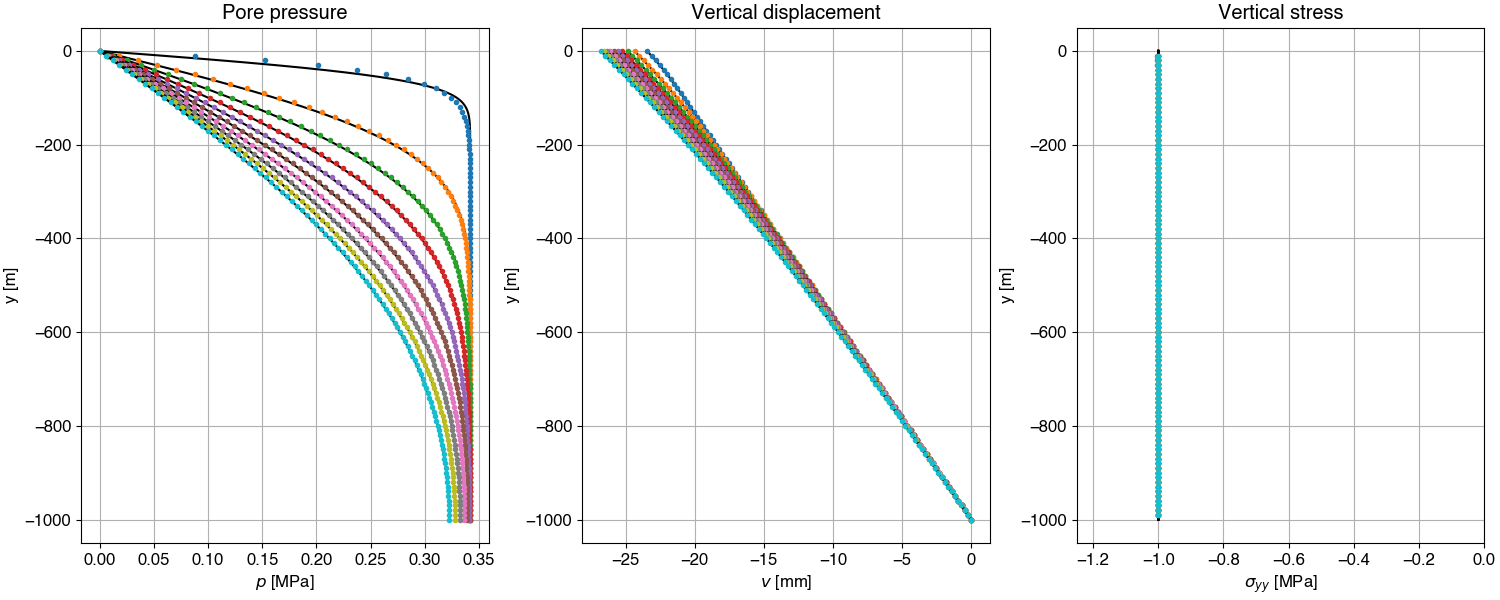

In [4]:
### Time loop to compute solution m given the linear system of equations A*m = b at each time step:

## Initialize figures:
fig, ax = plt.subplots(1,3,figsize = (15,6),constrained_layout=True)

## Parameters for analytical solution:
y_an = np.arange(-H,0.01,0.01)
v_ini = -(1-2*nu_u)/(2*G*(1-nu_u))*sigma_o*(y_an+H)
sigma_an = sigma_surf*np.ones((y_an.shape))

## Main time loop, plotting results every n_plot timestep: 
for n in np.arange(0,nt):    
    if n % n_plot == 0:
        
        # Compute analytical solution:
        sum_p = 0
        sum_v = 0

        for m in np.arange(0,1000):
            sum_p = sum_p + 1/(2*m+1)*np.exp(-(2*m+1)**2*np.pi**2*c*times[n]/(4*H**2))*np.sin((2*m+1)*np.pi*y_an/(2*H))
            sum_v = sum_v + 1/(2*m+1)**2*np.exp(-(2*m+1)**2*np.pi**2*c*times[n]/(4*H**2))*np.cos((2*m+1)*np.pi*-y_an/(2*H))

        v_an = v_ini-c_m*gamma*sigma_o*((H+y_an)-8*H/np.pi**2*sum_v)
        p_an = -(4*gamma*sigma_o/np.pi)*sum_p

        ax[0].plot(p_an/1e6,y_an,'-k')
        ax[0].set_xlabel("$p$ [MPa]")
        ax[0].set_ylabel("y [m]")
        ax[0].set_title('Pore pressure')
        ax[0].grid(True)
        
        ax[1].plot(v_an*1e3,y_an,'-k')
        ax[1].set_xlabel("$v$ [mm]")
        ax[1].set_ylabel("y [m]")
        ax[1].set_title('Vertical displacement')
        ax[1].grid(True)

        ax[2].plot(sigma_an/1e6,y_an,'-k')
        ax[2].set_xlabel("$\sigma_{yy}$ [MPa]")
        ax[2].set_ylabel("y [m]")
        ax[2].set_title('Vertical stress')
        ax[2].grid(True)
      
    # Initial b-vectors containing the RHS of each equation:
    
    b1 = np.zeros([nx*ny,1]) # b vector for fluid equation
    b2 = np.zeros([nx*ny,1]) # b vector for first mechanical equation
    b3 = np.zeros([nx*ny,1]) # b vector for second mechanical equation

    for i in np.arange(0,nx):
        for j in np.arange(0,ny):   

            # Top boundary:
            if j == ny-1: 
                b1[Number[i,j]] = 0 
                b2[Number[i,j]] = 0
                b3[Number[i,j]] = -2*sigma_surf/(G*dy)
            
            # Bottom boundary:
            elif j == 0:
                b2[Number[i,j]] = 0
                b3[Number[i,j]] = 0
                
                # Bottom left corner:
                if i == 0:
                     b1[Number[i,j]] = 1/(2*dx*dt)*(u[Number[i+1,j]])+1/(2*dy*dt)*(v[Number[i,j+1]])+S_eps/(alpha*dt)*p[Number[i,j]]  
                
                # Bottom right corner:
                elif i == nx-1:
                     b1[Number[i,j]] = 1/(2*dx*dt)*(-u[Number[i-1,j]])+1/(2*dy*dt)*(v[Number[i,j+1]])+S_eps/(alpha*dt)*p[Number[i,j]]  

                # Rest of bottom boundary:        
                else: 
                     b1[Number[i,j]] = 1/(2*dx*dt)*(u[Number[i+1,j]]-u[Number[i-1,j]])+1/(2*dy*dt)*(v[Number[i,j+1]])+S_eps/(alpha*dt)*p[Number[i,j]]  

            # Left boundary:            
            elif i == 0: 
                b1[Number[i,j]] = 1/(2*dx*dt)*(u[Number[i+1,j]])+1/(2*dy*dt)*(v[Number[i,j+1]]-v[Number[i,j-1]])+S_eps/(alpha*dt)*p[Number[i,j]]
                b2[Number[i,j]] = 0
                b3[Number[i,j]] = 0
           
            # Right boundary
            elif i == nx-1:              
                b1[Number[i,j]] = 1/(2*dx*dt)*(-u[Number[i-1,j]])+1/(2*dy*dt)*(v[Number[i,j+1]]-v[Number[i,j-1]])+S_eps/(alpha*dt)*p[Number[i,j]]              
                b2[Number[i,j]] = 0
                b3[Number[i,j]] = 0
                
            # Domain interior: 
            else: 
                b1[Number[i,j]] = 1/(2*dx*dt)*(u[Number[i+1,j]]-u[Number[i-1,j]])+1/(2*dy*dt)*(v[Number[i,j+1]]-v[Number[i,j-1]])+S_eps/(alpha*dt)*p[Number[i,j]]
                b2[Number[i,j]] = 0
                b3[Number[i,j]] = 0    

    b = np.concatenate((b1, b2, b3),axis=0)
    
    # Solve for solution vector m:
    m_sol = A_inv*b
    
    # Update p, u, and v: 
    p = m_sol[Number.flatten()]
    u = m_sol[Number.flatten()+nx*ny]
    v = m_sol[Number.flatten()+2*nx*ny]
    
    p_array = p.reshape((nx,ny))
    v_array = v.reshape((nx,ny))
    u_array = u.reshape((nx,ny))
   
    if n % n_plot == 0:
        
        for j in np.arange(1,ny-1):
            sigma_yy[j-1] = G*(2-2*nu)/(1-2*nu)*(v[j+1]-v[j-1])/(2*dy)-alpha*p[j]
        
        ax[0].plot(p_array[nx//2,:]/1e6,y,'.')
        ax[1].plot(v_array[nx//2,:]*1e3,y,'.')
        ax[2].plot(sigma_yy/1e6,y[1:ny-1],'.')
        ax[2].set_xlim(-1.25,0)
